In [94]:
import torch, torchvision
from torchvision import transforms
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline    
import sys, copy
from pathlib import Path
lib_dir = (Path("__file__").parent).resolve()
if str(lib_dir) not in sys.path: sys.path.insert(0, str(lib_dir))
from AdapAug.augmentations import augment_list
from AdapAug.controller import Controller
from AdapAug.data import Augmentation
from collections import Counter
from theconf import Config as C
from PIL import Image

In [2]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.ylabel('epoch')
    plt.show()
C.get()
C.get()["dataset"] = "cifar100"
exp_name = "c100_w402_cc_0"

In [118]:
plt.rcParams['figure.figsize'] = [3, 2]
plt.rcParams['figure.dpi'] = 100

In [236]:
transform_ = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
dataset = torchvision.datasets.CIFAR100('/home/server36/data/',download=False, train=True, transform=transform_)
nonorm_dataset = torchvision.datasets.CIFAR100('/home/server36/data/',download=False, train=True, transform=transforms.ToTensor())

_loader = torch.utils.data.DataLoader(
                        dataset, batch_size=8, shuffle=False, num_workers=4,
                        drop_last=False)
_nonorm_loader = torch.utils.data.DataLoader(
                        nonorm_dataset, batch_size=8, shuffle=False, num_workers=4,
                        drop_last=False)
loader = iter(_loader)
nonorm_loader = iter(_nonorm_loader)

In [238]:
imgs, labels = loader.next()
n_imgs, n_labels = nonorm_loader.next()
print(labels == n_labels)
print(imgs.shape)

tensor([True, True, True, True, True, True, True, True])
torch.Size([8, 3, 32, 32])


In [92]:
ops = augment_list(False)

img = n_imgs[2]
print(img.shape)
aug_imgs = []
for op in ops:
    pol = [[(op[0].__name__,1.0,1.0)]]
    pil_img = transforms.ToPILImage()(img.cpu())
    augment = Augmentation(pol)
    aug_img = transforms.ToTensor()(augment(pil_img))
    aug_imgs.append(aug_img)
aug_imgs = torch.stack(aug_imgs)
print(aug_imgs.shape)

torch.Size([3, 32, 32])
[('ShearX', 1.0, 1.0)]
[('ShearY', 1.0, 1.0)]
[('TranslateX', 1.0, 1.0)]
[('TranslateY', 1.0, 1.0)]
[('Rotate', 1.0, 1.0)]
[('AutoContrast', 1.0, 1.0)]
[('Invert', 1.0, 1.0)]
[('Equalize', 1.0, 1.0)]
[('Solarize', 1.0, 1.0)]
[('Posterize', 1.0, 1.0)]
[('Contrast', 1.0, 1.0)]
[('Color', 1.0, 1.0)]
[('Brightness', 1.0, 1.0)]
[('Sharpness', 1.0, 1.0)]
[('Cutout', 1.0, 1.0)]
torch.Size([15, 3, 32, 32])


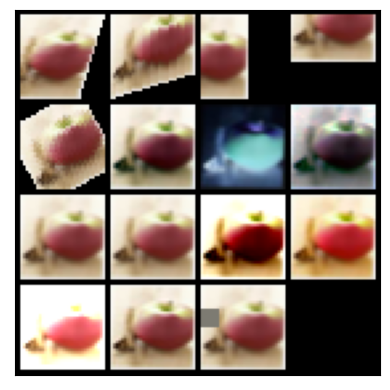

In [93]:
img = torchvision.utils.make_grid(aug_imgs, nrow=4)

plt.imshow(np.transpose(img, (1, 2, 0)))
# ax1.set_title('originals')
# ax2.set_title('augmented images')
# ax2.set_xlabel('epoch')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("ops.pdf")
plt.show()

In [15]:
controller = Controller(n_subpolicy=2, operation_prob=0).cuda()
policies = []
for epoch in range(30,201,30):
    ctl = torch.load(f"/home/server36/yongsu/adapaug/AdapAug/models/{exp_name}/ctl_network.pt-{epoch}")
    controller.load_state_dict(ctl['ctl_state_dict'])
    _,_, sampled_policy = controller(imgs.cuda())
    policies.append(sampled_policy)
print(policies[-1].shape)

torch.Size([8, 2, 2, 3])


In [239]:
all_aug_imgs = []
all_applied_policy = []
for policy in policies:
    aug_imgs = []
    applied_policy = []
    for img, pol in zip(n_imgs, policy):
        # policy: (list:list:tuple) [num_policy, n_op, 3]
        pil_img = transforms.ToPILImage()(img.cpu())
        augment = Augmentation(pol)
        aug_img = transforms.ToTensor()(augment(pil_img))
        aug_imgs.append(aug_img)
        applied_policy.append(augment.policy)
    aug_imgs = torch.stack(aug_imgs)
    all_aug_imgs.append(aug_imgs)
    all_applied_policy.append(applied_policy)
all_aug_imgs = torch.stack(all_aug_imgs)
print(all_aug_imgs.shape)

tensor([[10, 10,  4],
        [ 7, 10,  4]], device='cuda:0')
tensor([[10, 10,  1],
        [14, 10,  2]], device='cuda:0')
tensor([[ 9, 10,  5],
        [ 4, 10,  1]], device='cuda:0')
tensor([[11, 10,  9],
        [ 6, 10,  1]], device='cuda:0')
tensor([[ 3, 10,  1],
        [ 3, 10,  4]], device='cuda:0')
tensor([[ 7, 10,  9],
        [ 9, 10,  3]], device='cuda:0')
tensor([[11, 10,  3],
        [ 9, 10,  7]], device='cuda:0')
tensor([[14, 10,  0],
        [ 7, 10,  3]], device='cuda:0')
tensor([[13, 10,  9],
        [ 8, 10,  9]], device='cuda:0')
tensor([[11, 10,  4],
        [14, 10,  3]], device='cuda:0')
tensor([[ 5, 10,  2],
        [ 6, 10,  0]], device='cuda:0')
tensor([[ 4, 10,  0],
        [ 3, 10,  4]], device='cuda:0')
tensor([[12, 10,  0],
        [ 8, 10,  8]], device='cuda:0')
tensor([[ 5, 10,  0],
        [ 5, 10,  3]], device='cuda:0')
tensor([[ 3, 10,  1],
        [ 4, 10,  9]], device='cuda:0')
tensor([[ 8, 10,  3],
        [ 1, 10,  9]], device='cuda:0')
tensor([

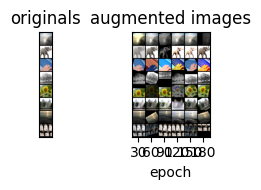

In [240]:
fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 6]})
ori_img = torchvision.utils.make_grid(n_imgs, nrow=1)
nporiimg = ori_img.numpy()

img = torchvision.utils.make_grid(all_aug_imgs.transpose(0,1).reshape(-1,3,32,32), nrow=6)
npimg = img.numpy()

ax1.imshow(np.transpose(nporiimg, (1, 2, 0)))
ax2.imshow(np.transpose(npimg, (1, 2, 0)))
ax1.set_title('originals')
ax2.set_title('augmented images')
ax2.set_xlabel('epoch')
for ax in [ax1,ax2]:
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
# bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# width, height = bbox.width, bbox.height
ax2.set_xticks(np.arange(17,200,34))
ax2.set_xticklabels([30,60,90,120,150,180])
#     ax.tick_params(
#         axis='y',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
fig.tight_layout()
plt.savefig("aug_process2.pdf")
plt.show()


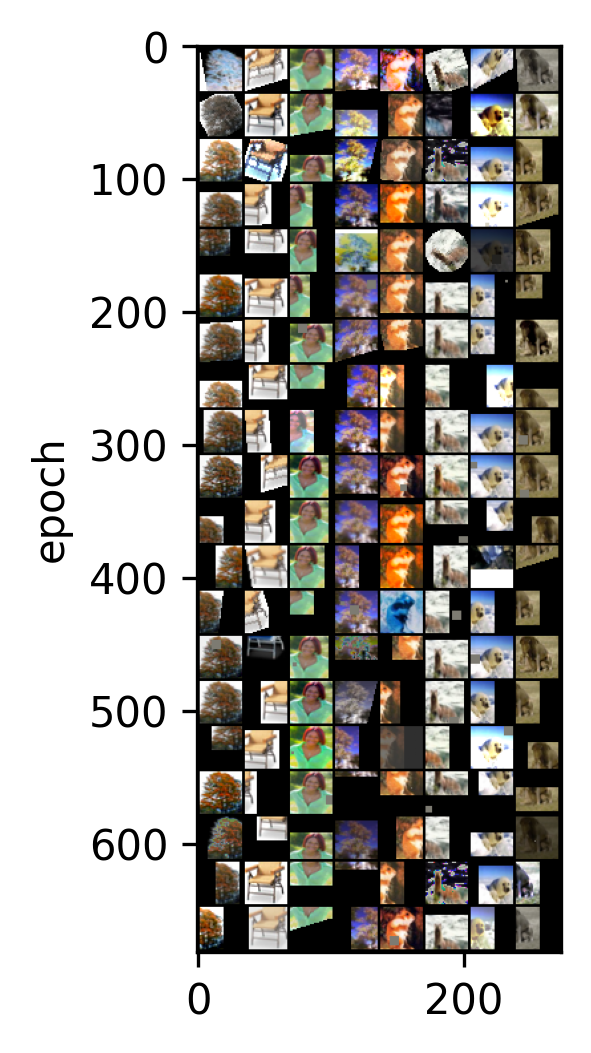

In [162]:
plt.rcParams['figure.dpi'] = 300
imshow(torchvision.utils.make_grid(all_aug_imgs.reshape(-1,3,32,32)))

In [421]:
# exp_name = "c100_w402_cc"
controller = Controller(n_subpolicy=2, operation_prob=0).cuda()
ctl = torch.load(f"/home/server36/yongsu/adapaug/AdapAug/models/{exp_name}/ctl_network.pt")
policies = []
for epoch in range(1000):
    controller.load_state_dict(ctl['ctl_state_dict'])
    _,_, sampled_policy = controller(imgs.cuda())
    policies.append(sampled_policy)
print(policies[-1].shape)

torch.Size([8, 2, 2, 3])


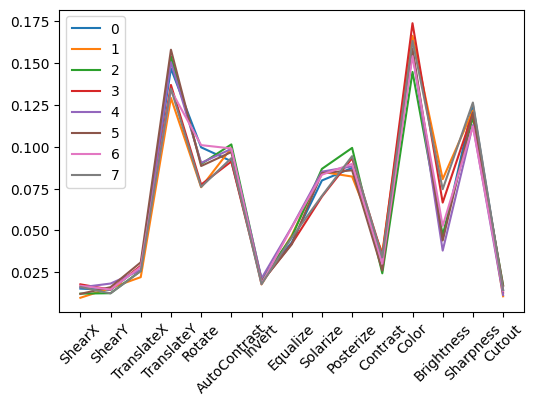

In [422]:
ops = augment_list(False)
# policies -> [100,8,2,2,3]
# policy_pool -> [N,3]
for t in range(8):
    policy_pool = torch.stack([policies[j][t] for j in range(1000)]).reshape(-1,3)
    elem = []
    for i, op in enumerate(ops):
        cnt = torch.sum(policy_pool[:,0] == i).item()
        mag = torch.mean(policy_pool[policy_pool[:,0] == i][:,2].float()).item()
        if np.isnan(mag): mag = 0.
    #     print(op[0].__name__,cnt,mag)
    #     plt.text(op[0].__name__,cnt*mag, f"{mag}")
        elem.append(cnt*mag)
    elem = np.array(elem)
    plt.plot([op[0].__name__ for op in ops],elem / np.sum(elem), label=str(t))
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [324]:
# all_applied_policy -> [20,8,2,3]
print(all_applied_policy[0])
mags = [ x[0].sum(0)[-1].item() for x in all_applied_policy]
print(mags)

[tensor([[10, 10,  5],
        [ 8, 10,  5]], device='cuda:0'), tensor([[10, 10,  6],
        [11, 10,  1]], device='cuda:0'), tensor([[ 0, 10,  9],
        [ 5, 10,  2]], device='cuda:0'), tensor([[10, 10,  4],
        [ 1, 10,  4]], device='cuda:0'), tensor([[ 6, 10,  0],
        [10, 10,  4]], device='cuda:0'), tensor([[12, 10,  7],
        [10, 10,  4]], device='cuda:0'), tensor([[12, 10,  7],
        [13, 10,  0]], device='cuda:0'), tensor([[14, 10,  7],
        [ 3, 10,  3]], device='cuda:0')]
[10, 10, 9, 4, 9, 12, 6, 15, 10, 10, 9, 13, 1, 5, 18, 18, 9, 18, 6, 18]


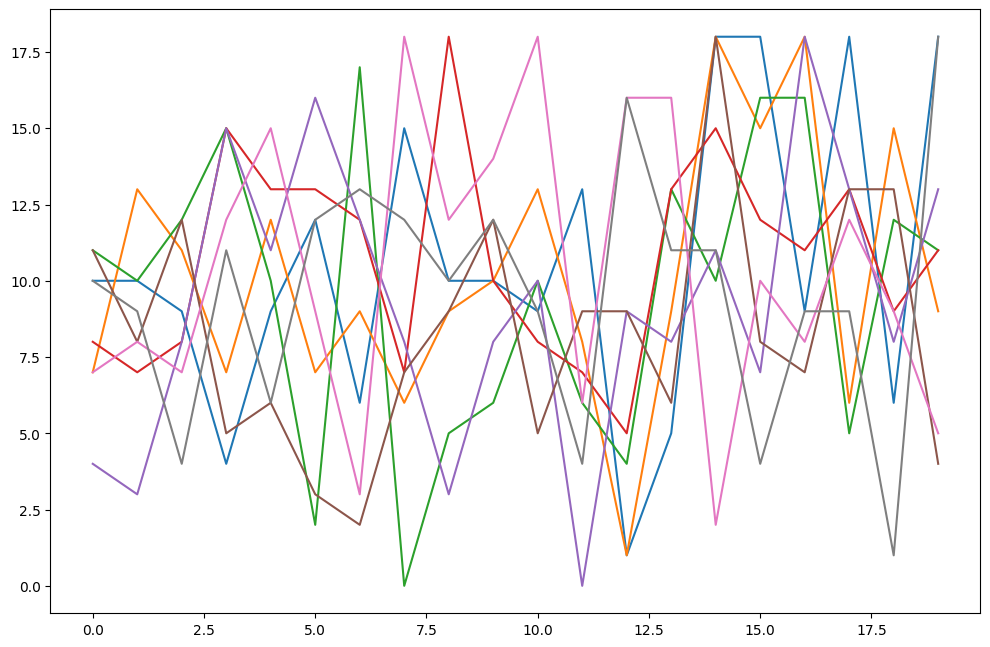

In [325]:
for i in range(len(all_applied_policy[0])):
    mags = [ x[i].sum(0)[-1].item() for x in all_applied_policy]
    plt.plot(mags, label=str(i))
plt.show()

# Main Analysis

In [256]:
exp_name = "cifar100_v3_reinforce_np2_aw5.000e-01_rt4_ew1.000000e-05_0"
target = torch.load(f"/home/server36/yongsu/adapaug/AdapAug/models/{exp_name}/target_network.pt")
ctl = torch.load(f"/home/server36/yongsu/adapaug/AdapAug/models/{exp_name}/ctl_network.pt")

print(target.keys())
print(ctl.keys())

print(ctl['div_trace'].keys())
print(ctl['aff_trace'].keys())

dict_keys(['epoch', 'model', 'optimizer_state_dict', 'policy', 'test_metrics'])
dict_keys(['epoch', 'ctl_state_dict', 'optimizer_state_dict', 'aff_trace', 'div_trace', 'train_metrics'])
dict_keys(['cnt', 'time', 'acc', 'pol_loss', 'reward'])
dict_keys(['cnt', 'time', 'acc', 'pol_loss', 'reward'])


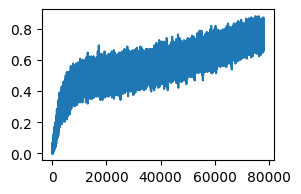

In [257]:
plt.plot(np.array(ctl['div_trace']['acc']) / np.array(ctl['div_trace']['cnt']))

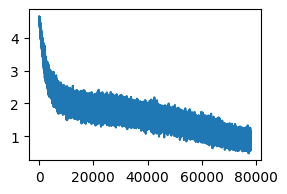

In [258]:
plt.plot(np.array(ctl['div_trace']['reward']) / np.array(ctl['div_trace']['cnt']))

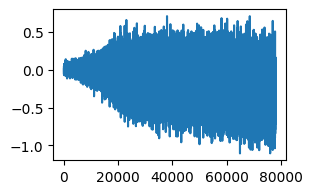

In [259]:
plt.plot(np.array(ctl['div_trace']['pol_loss']) / np.array(ctl['div_trace']['cnt']))

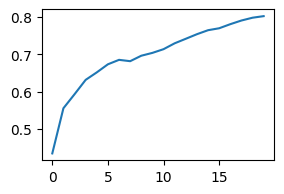

In [260]:
plt.plot([x['top1'] for x in target['test_metrics']])

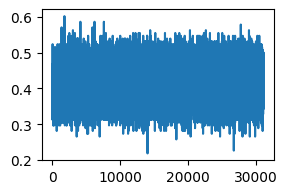

In [261]:
plt.plot(np.array(ctl['aff_trace']['acc']) / np.array(ctl['aff_trace']['cnt']))

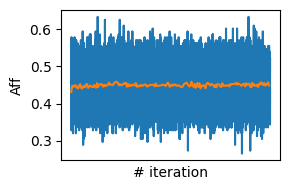

In [263]:
rwd = (np.array(ctl['aff_trace']['reward']) / np.array(ctl['aff_trace']['cnt']))# / 6. + 0.8
plt.plot(rwd)
rwd = rwd.reshape(200, -1)
plt.plot(np.arange(0,rwd.shape[0]*rwd.shape[1],rwd.shape[1]), np.mean(rwd,1))
plt.xticks([])
# plt.yticks([])
plt.xlabel("# iteration")
plt.ylabel("Aff")
plt.tight_layout()
plt.show()

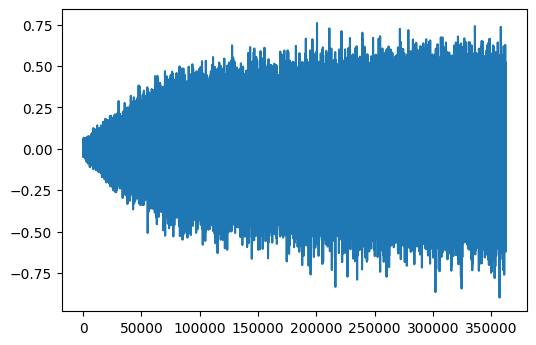

In [28]:
plt.plot(np.array(ctl['aff_trace']['pol_loss']) / np.array(ctl['aff_trace']['cnt']))

In [29]:
target['test_metrics']

[{'loss': 0.12354634697740804,
  'top1': 0.9687307929069482,
  'top5': 0.9957744314689613},
 {'loss': 0.10654558388020594,
  'top1': 0.9730331899200984,
  'top5': 0.9965043023970498},
 {'loss': 0.10367933020668851,
  'top1': 0.9736478181067023,
  'top5': 0.9964658881376767},
 {'loss': 0.10846476048487567,
  'top1': 0.9734557468098369,
  'top5': 0.9962738168408113},
 {'loss': 0.09587494404236635,
  'top1': 0.9765673017824217,
  'top5': 0.9965427166564229},
 {'loss': 0.09010294607778085,
  'top1': 0.9787569145666871,
  'top5': 0.9967732022126613},
 {'loss': 0.08974355365852033,
  'top1': 0.9786032575291949,
  'top5': 0.9963890596189305},
 {'loss': 0.0884426339599862,
  'top1': 0.9786800860845757,
  'top5': 0.9965811309157959},
 {'loss': 0.08994580607932261,
  'top1': 0.9780270436752333,
  'top5': 0.9971189305470191},
 {'loss': 0.08408682230349399,
  'top1': 0.9799861709032603,
  'top5': 0.9975414874001229},
 {'loss': 0.0812491803866775,
  'top1': 0.9809465273875874,
  'top5': 0.996657959

In [33]:
target = torch.load(f"/home/server36/yongsu/adapaug/AdapAug/models/{exp_name}/ctl_network.pt-180")
len(target['policy']) # [epoch,train_len,M*batch,NP,3]

10

In [34]:
ops = augment_list(False)
cdfs = []
for policy in target['policy']:
    elem = []
    policy_pool = torch.from_numpy(np.concatenate(policy)).reshape(-1,3)
    for i, op in enumerate(ops):
#         cnt = torch.sum(policy_pool[:,0] == i).item()
        mag = torch.sum(policy_pool[policy_pool[:,0] == i][:,2].float()).item()
        if np.isnan(mag): mag = 0.
#         print(op[0].__name__,mag)
        elem.append(mag)
    cdf = np.array([ sum(elem[i:])for i, el in enumerate(elem)])
    cdf[0] = sum(elem)
#     cdf /= cdf[0]
    cdfs.append(cdf)
cdfs = np.array(cdfs)
print(cdfs.shape)

(10, 15)


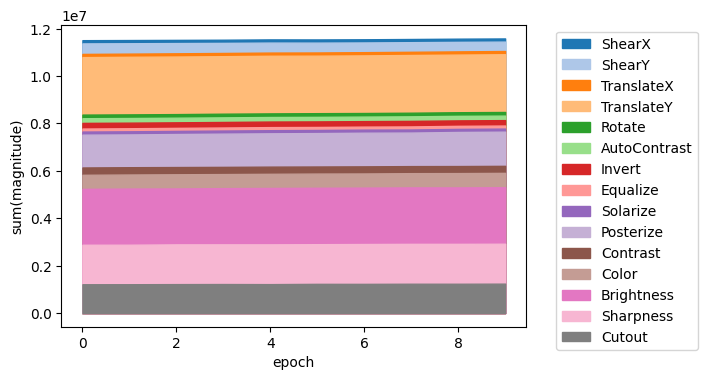

In [35]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
cm = plt.cm.get_cmap('tab20')
for i, op in enumerate(ops):
#     plt.bar(list(range(len(cdfs))),cdfs[:,i], label=op[0].__name__)
#     plt.plot(list(range(len(cdfs))),cdfs[:,i])
    plt.fill_between(list(range(len(cdfs))), cdfs[:,i], color=cm.colors[i], label=op[0].__name__)

    plt.xlabel("epoch")
plt.ylabel("sum(magnitude)")
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("op-dist-aff.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [36]:
policy_pool = torch.from_numpy(np.concatenate(target['policy'][-1])).reshape(-1,3)
print(policy_pool.shape)
print(Counter(policy_pool[:,0].numpy()))
print(Counter(policy_pool[:,2].numpy()))

torch.Size([2417152, 3])
Counter({3: 508426, 12: 497538, 13: 351864, 9: 300781, 14: 258077, 11: 126206, 1: 82699, 10: 62031, 6: 47982, 5: 39816, 4: 32090, 2: 28362, 0: 27618, 8: 26963, 7: 26699})
Counter({9: 519159, 3: 462321, 2: 452722, 4: 264748, 5: 232071, 6: 160171, 7: 94743, 8: 88099, 0: 73613, 1: 69505})


ShearX 27618 4.811137676239014
ShearY 82699 4.8001909255981445
TranslateX 28362 4.779987335205078
TranslateY 508426 4.791995525360107
Rotate 32090 4.784948348999023
AutoContrast 39816 4.771297931671143
Invert 47982 4.763202667236328
Equalize 26699 4.836885452270508
Solarize 26963 4.809665203094482
Posterize 300781 4.793441295623779
Contrast 62031 4.776257038116455
Color 126206 4.809517860412598
Brightness 497538 4.789427280426025
Sharpness 351864 4.785508155822754
Cutout 258077 4.7978434562683105


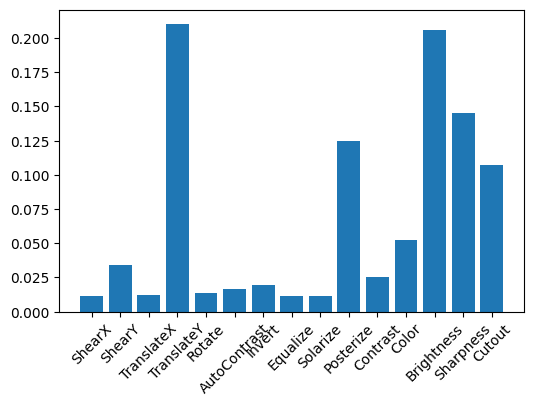

In [37]:
ops = augment_list(False)
elem = []
for i, op in enumerate(ops):
    cnt = torch.sum(policy_pool[:,0] == i).item()
    mag = torch.mean(policy_pool[policy_pool[:,0] == i][:,2].float()).item()
    if np.isnan(mag): mag = 0.
    print(op[0].__name__,cnt,mag)
#     plt.text(op[0].__name__,cnt*mag, f"{mag}")
    elem.append(cnt*mag)
elem = np.array(elem)
plt.bar([op[0].__name__ for op in ops],elem / np.sum(elem))
plt.xticks(rotation=45)
plt.show()

In [356]:
aug_data = np.array([97.61,97.56,97.51,97.50, 97.3])
data = np.array([84.23,84.23,84.21,84.11,84.08,84.03,83.69,83.57,83.35,83.08])
print(f"aug {100-np.mean(aug_data):.2f}+-{np.std(aug_data):.2f}")
print(f"def {np.mean(data):.2f}+-{np.std(data):.2f}")

aug 2.50+-0.11
def 83.86+-0.39


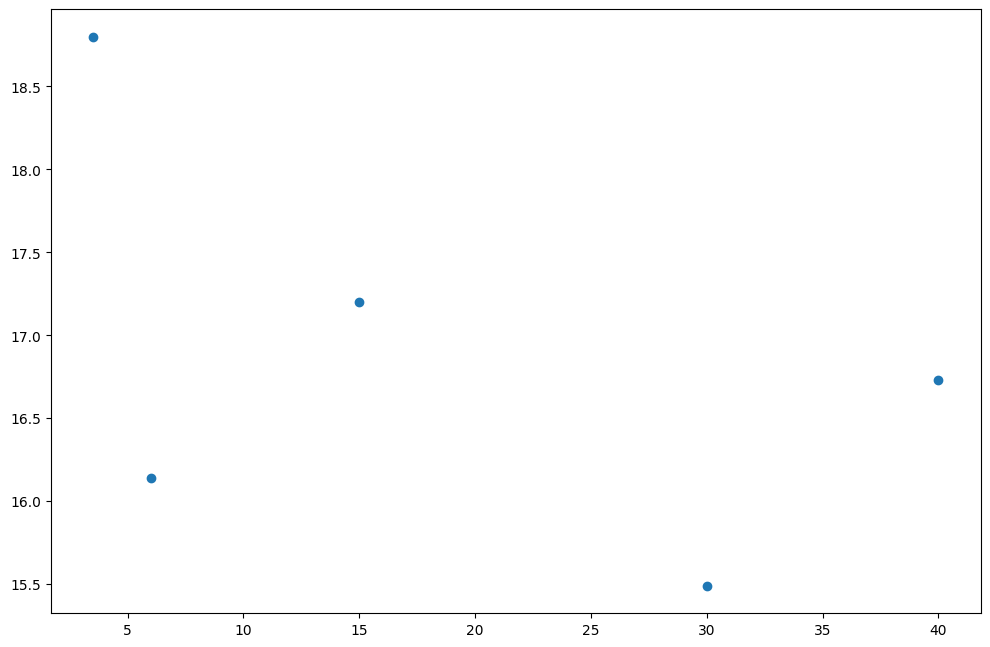

In [357]:
plt.scatter([3.5,40,15,30,6],[18.8,16.73,17.2,15.49,16.14])